## Trabalho Prático 1

## A

i) Determine e mostre a resposta em frequência (amplitude e fase). Apresente o Diagrama-Polos-Zeros. Nota:
Resolva para conjunto de ganhos separadamente.


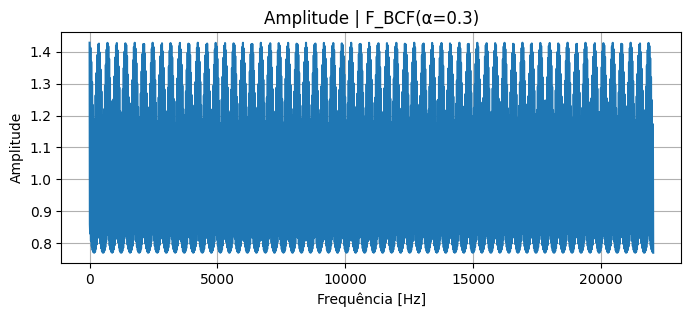

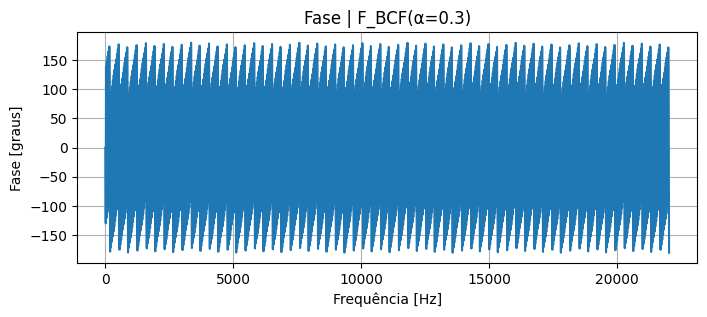

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


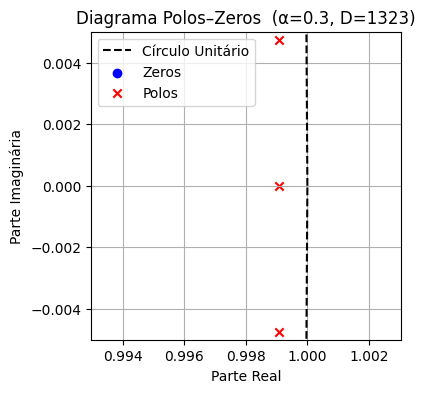

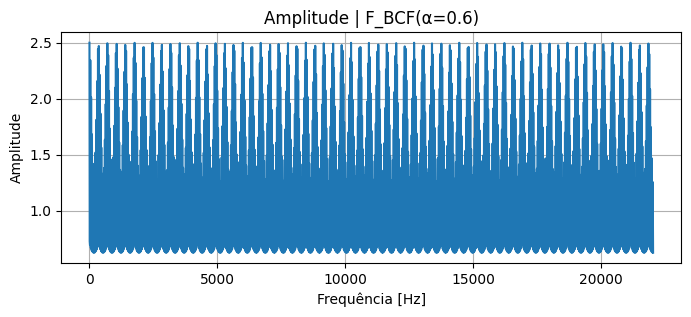

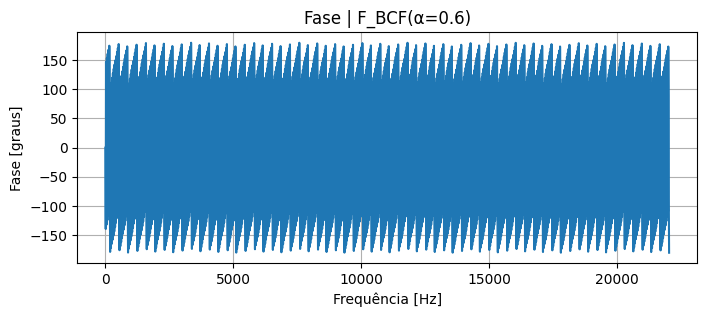

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


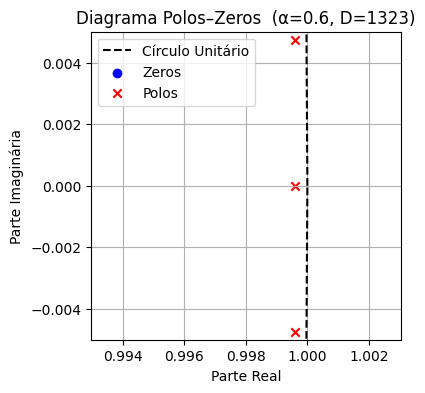

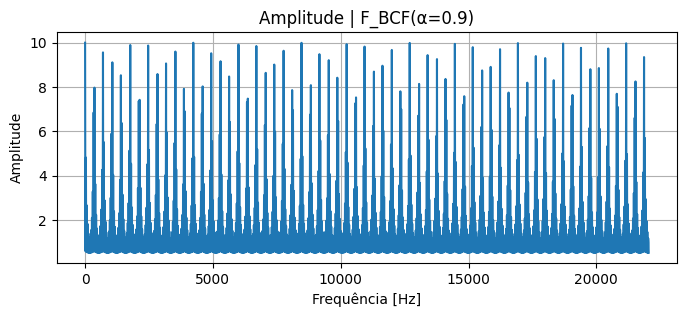

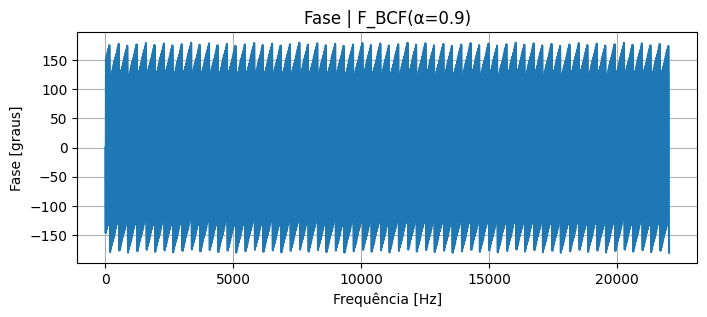

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


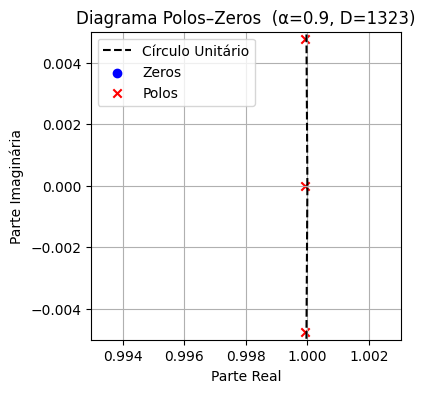

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# Feedback Comb Filter
# F_BCF(α, D_c) = z^{-D_c} / (1 - α z^{-D_c})
# ==============================

# --- Parâmetros ---
fs = 44100          # frequência de amostragem [Hz]
delay_ms = 30       # atraso (milissegundos)
D = int(round(delay_ms * fs / 1000))  # atraso em amostras

# Conjunto de ganhos a analisar separadamente
alpha_list = [0.3, 0.6, 0.9]

# Grelha de frequências
N = 2048
w = np.linspace(0, np.pi, N)
f = w * fs / (2 * np.pi)

# --- Loop principal ---
for alpha in alpha_list:
    # Função de transferência no domínio da frequência
    ejwD = np.exp(-1j * w * D)
    H = ejwD / (1 - alpha * ejwD)

    # Resposta em amplitude e fase
    H_abs = np.abs(H)
    H_ang = np.angle(H) * 180 / np.pi

    # ---------- Gráfico de amplitude ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_abs)
    plt.title(f"Amplitude | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # ---------- Gráfico de fase ----------
    plt.figure(figsize=(8, 3))
    plt.plot(f, H_ang)
    plt.title(f"Fase | F_BCF(α={alpha})")
    plt.xlabel("Frequência [Hz]")
    plt.ylabel("Fase [graus]")
    plt.grid(True)
    plt.show()

    # ---------- Diagrama Polos–Zeros (inlined) ----------
    # Zeros: D zeros na origem
    z = np.zeros(D, dtype=complex)
    # Polos: soluções de z^D = α
    r = np.abs(alpha)**(1/D)
    angles = 2 * np.pi * np.arange(D) / D
    p = r * np.exp(1j * angles)

    plt.figure(figsize=(4, 4))
    theta = np.linspace(0, 2*np.pi, 512)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo Unitário')
    plt.scatter(np.real(z), np.imag(z), marker='o', color='b', label='Zeros')
    plt.scatter(np.real(p), np.imag(p), marker='x', color='r', label='Polos')
    plt.axis('equal')
    plt.xlabel("Parte Real")
    plt.ylabel("Parte Imaginária")
    plt.title(f"Diagrama Polos–Zeros  (α={alpha}, D={D})")
    plt.legend()
    plt.grid(True)
    plt.xlim(0.995, 1.001)
    plt.ylim(-0.005, 0.005)
    plt.show()


II)Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade.

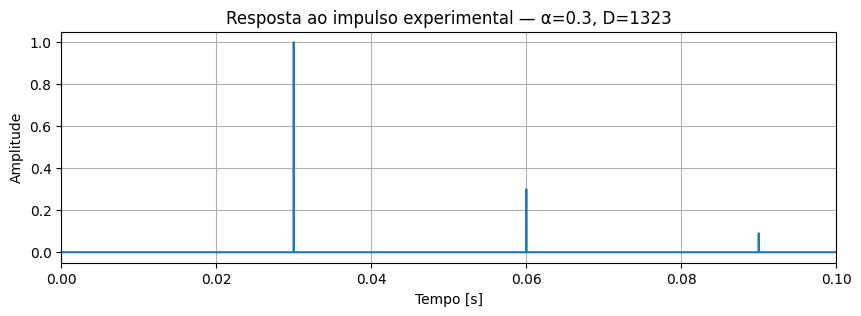

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.3_D1323_fs44100.wav


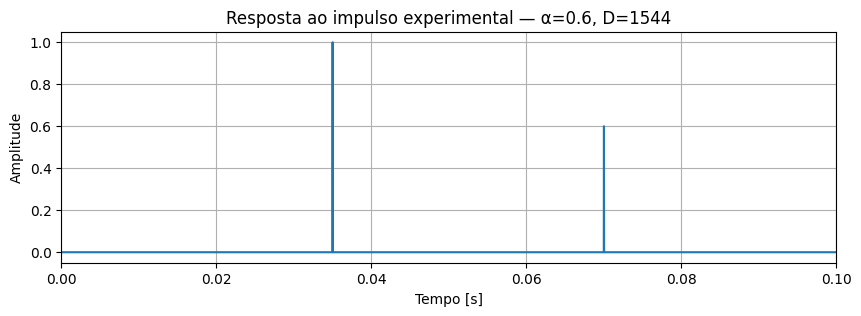

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.6_D1544_fs44100.wav


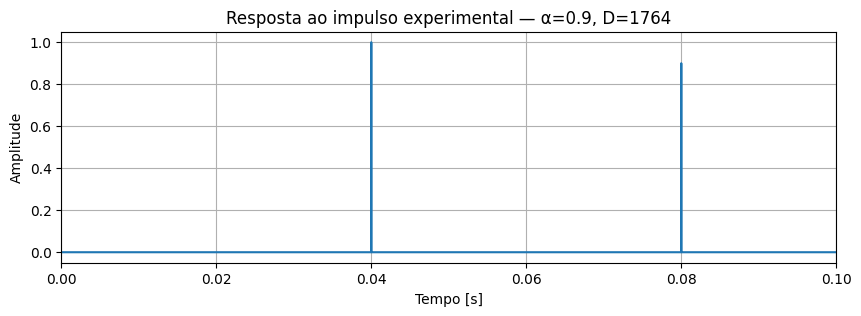

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.9_D1764_fs44100.wav


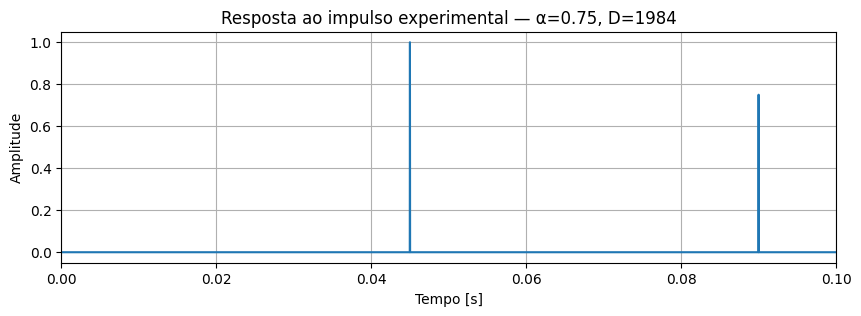

Guardado resposta ao impulso experimental em impulse_FBCF_alpha0.75_D1984_fs44100.wav


Guardado resposta ao impulso do comb-bank em impulse_FBCF_combbank_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100.wav


Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import soundfile as sf
from IPython.display import Audio, display

# ==============================
# Exercício II: Resposta ao impulso experimental
# - calcula resposta ao impulso aplicando um delta
# - plota a resposta
# - guarda como WAV
# - reproduz inline
# ==============================

fs = 44100
# Usar o mesmo conjunto de 4 combs do Exercício III para consistência
delays_ms = [30, 35, 40, 45]
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
alphas = [0.3, 0.6, 0.9, 0.75]

# comprimento do delta/resposta (vê-se decaimento) — usa maior D para garantir cobertura
L = 8 * max(D_list) if max(D_list)>0 else 1024

delta = np.zeros(L, dtype=np.float32)
delta[0] = 1.0

# Calcular e guardar respostas impulsionais individuais e a resposta somada (combbank)
h_combbank = np.zeros(L, dtype=np.float32)
for alpha, D in zip(alphas, D_list):
    # Inlined apply_fbcf_impulse logic
    b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
    a = np.hstack([[1.0], np.zeros(D-1), [-alpha]]).astype(np.float32)
    h_exp = lfilter(b, a, delta)

    # Plot - resposta ao impulso no domínio do tempo
    t = np.arange(len(h_exp)) / fs
    plt.figure(figsize=(10,3))
    plt.plot(t, h_exp)
    plt.title(f"Resposta ao impulso experimental — α={alpha}, D={D}")
    plt.xlabel("Tempo [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.xlim(0, min(0.1, t[-1]))  # mostra os primeiros 100 ms por defeito
    plt.show()

    # Guardar como WAV (normalizado para evitar clipping)
    h_save = h_exp / (np.max(np.abs(h_exp)) + 1e-12)
    fname = f"impulse_FBCF_alpha{alpha}_D{D}_fs{fs}.wav"
    sf.write(fname, h_save.astype(np.float32), fs)
    print('Guardado resposta ao impulso experimental em', fname)

    # Reproduzir inline (nota: reprodução funciona no Jupyter)
    display(Audio(h_save, rate=fs))

    # acumular na resposta do banco
    h_combbank[:len(h_exp)] += h_exp

# Normalizar e guardar a resposta impulsional do comb-bank (soma dos 4 combs)
h_cb_save = h_combbank / (np.max(np.abs(h_combbank)) + 1e-12)
fname_cb = f"impulse_FBCF_combbank_alphas{'-'.join(str(a).replace('.', 'p') for a in alphas)}_delays{'-'.join(str(d) for d in delays_ms)}_fs{fs}.wav"
sf.write(fname_cb, h_cb_save.astype(np.float32), fs)
print('Guardado resposta ao impulso do comb-bank em', fname_cb)
display(Audio(h_cb_save, rate=fs))

print('Exercício II concluído: respostas impulsionais individuais e do comb-bank geradas, gravadas e reproduzidas.')


III)Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade

Neste bloco geramos a resposta ao impulso (entrada delta), comparamos com a resposta teórica, guardamos o impulso como WAV e aplicamos o filtro a sinais de teste: seno, chirp e ruído branco. Não é usado o módulo `os`; usamos `pathlib.Path` para manipular caminhos.

In [ ]:
import numpy as np
from scipy.signal import lfilter
from scipy.signal import chirp
import soundfile as sf

fs = 44100
delays_ms = [30, 35, 40, 45]
D_list = [int(round(dms * fs / 1000)) for dms in delays_ms]
alphas = [0.3, 0.6, 0.9, 0.75]

dur = 2.0
N = int(dur * fs)
t = np.arange(N) / fs

sine = 0.6 * np.sin(2*np.pi*1000*t).astype(np.float32)
chirp_sig = 0.6 * chirp(t, f0=100, f1=6000, t1=dur, method='linear').astype(np.float32)
noise = 0.3 * np.random.randn(N).astype(np.float32)

alphas_tag = "-".join(str(a).replace('.', 'p') for a in alphas)
delays_tag = "-".join(str(d) for d in delays_ms)

# Processar sinais de teste: gravar ficheiro WET-ONLY estéreo (L=wet, R=wet)
for name, sig in [('sine1k', sine), ('chirp', chirp_sig), ('noise', noise)]:
    wet = np.zeros_like(sig, dtype=np.float32)
    for alpha_val, D in zip(alphas, D_list):
        b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
        a_coef = np.hstack([[1.0], np.zeros(D-1), [-alpha_val]]).astype(np.float32)
        wet += lfilter(b, a_coef, sig)

    # Normalizar só o wet
    max_abs = np.max(np.abs(wet))
    if max_abs > 0:
        wet = wet / (max_abs + 1e-12)

    wet_stereo = np.stack([wet, wet], axis=1)
    # Normalização final de segurança
    wet_stereo = wet_stereo / (np.max(np.abs(wet_stereo)) + 1e-12)

    outname = f"{name}_FBCF_combbank_WETONLY_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    sf.write(outname, wet_stereo.astype(np.float32), fs)
    print('Guardado', outname)

try:
    audio, sf_fs = sf.read('audio.wav', always_2d=True)
    if sf_fs != fs:
        print(f'AVISO: audio.wav tem taxa {sf_fs}Hz diferente de {fs}Hz — será processado sem resample.')
    audio_mono = np.mean(audio, axis=1).astype(np.float32)

    wet_audio = np.zeros_like(audio_mono, dtype=np.float32)
    for alpha_val, D in zip(alphas, D_list):
        b = np.hstack([np.zeros(D), [1.0]]).astype(np.float32)
        a_coef = np.hstack([[1.0], np.zeros(D-1), [-alpha_val]]).astype(np.float32)
        wet_audio += lfilter(b, a_coef, audio_mono)

    # Normaliza só o wet
    max_abs = np.max(np.abs(wet_audio))
    if max_abs > 0:
        wet_audio = wet_audio / (max_abs + 1e-12)

    wet_audio_st = np.stack([wet_audio, wet_audio], axis=1)
    wet_audio_st = wet_audio_st / (np.max(np.abs(wet_audio_st)) + 1e-12)

    out_audio = f"audio_FBCF_combbank_WETONLY_alphas{alphas_tag}_delays{delays_tag}_fs{fs}_stereo.wav"
    sf.write(out_audio, wet_audio_st.astype(np.float32), fs)
    print('Guardado', out_audio)

except Exception as e:
    print('audio.wav não encontrado ou não pôde ser lido; ficheiro ignorado. (Detalhe:', e, ')')

print('Exercício III concluído: WET-ONLY gerado para sinais e (se existir) audio.wav.')


Guardado sine1k_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Guardado chirp_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Guardado noise_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Guardado audio_FBCF_combbank_WETONLY_alphas0p3-0p6-0p9-0p75_delays30-35-40-45_fs44100_stereo.wav
Exercício III concluído: WET-ONLY gerado para sinais e (se existir) audio.wav.




## B

i) Determinar e mostrar a resposta em frequência (amplitude e fase) e apresentar o diagrama polos-zeros.
Resolver para um conjunto de ganhos separadamente (cada ganho em figura própria).

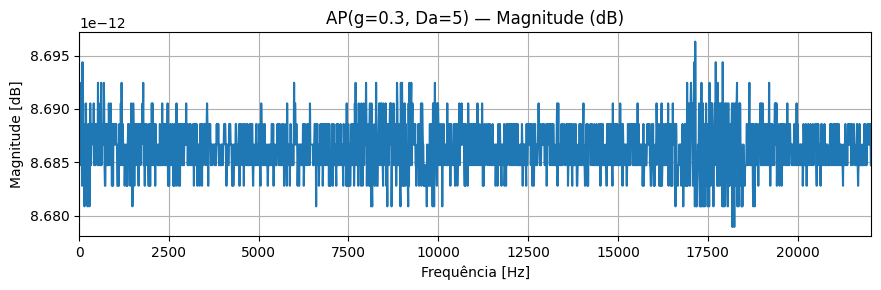

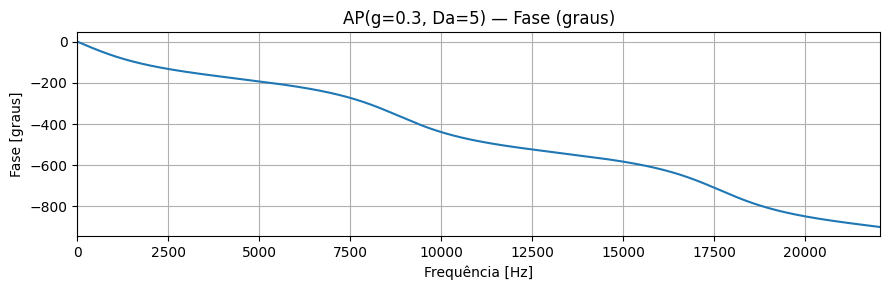

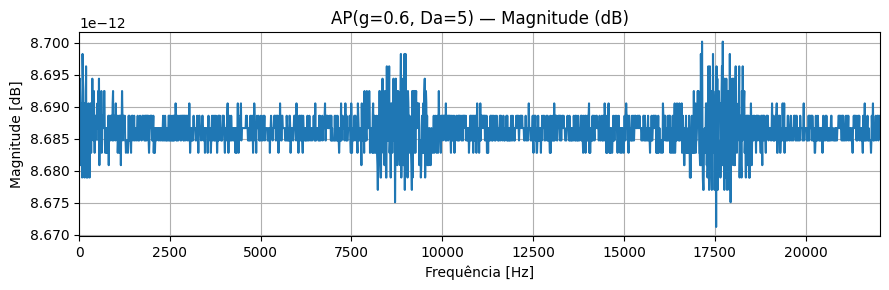

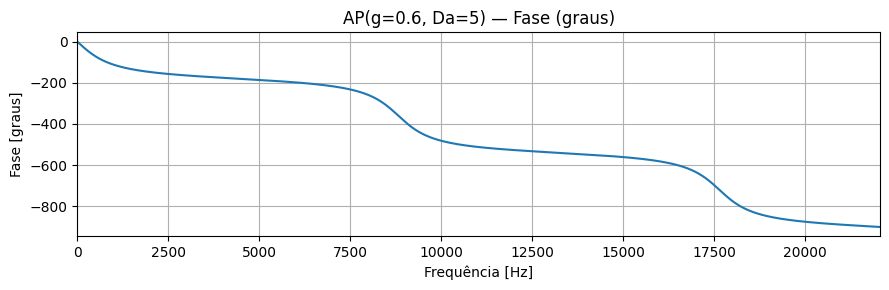

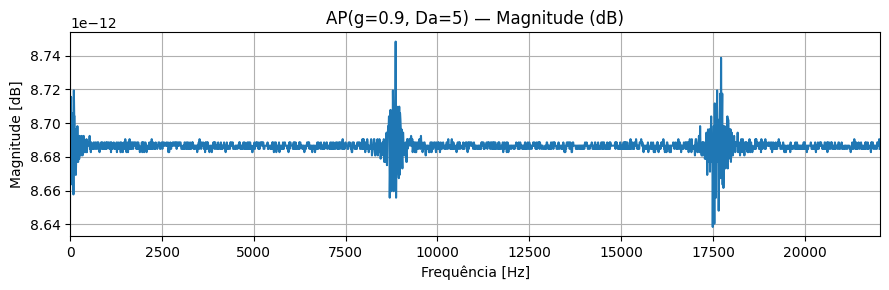

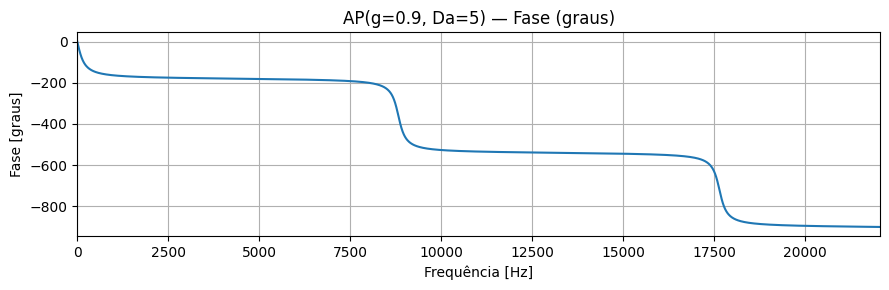

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz


fs = 44100  # taxa de amostragem (Hz)
Da = 5      # atraso em amostras (pode alterar conforme pedido)
gains = [0.3, 0.6, 0.9]  # conjunto de ganhos a analisar separadamente

for g in gains:
    b = np.zeros(Da+1)
    a = np.zeros(Da+1)
    b[0] = -g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -g

    w, H = freqz(b, a, worN=2048)
    f = w * fs / (2 * np.pi)

    # Magnitude (dB) e fase (graus, unwrap para suavizar)
    plt.figure(figsize=(9, 3))
    plt.plot(f, 20*np.log10(np.abs(H) + 1e-12))
    plt.title(f'AP(g={g}, Da={Da}) — Magnitude (dB)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Magnitude [dB]')
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 3))
    plt.plot(f, np.unwrap(np.angle(H)) * 180/np.pi)
    plt.title(f'AP(g={g}, Da={Da}) — Fase (graus)')
    plt.xlabel('Frequência [Hz]')
    plt.ylabel('Fase [graus]')
    plt.grid(True)
    plt.xlim(0, fs/2)
    plt.tight_layout()
    plt.show()


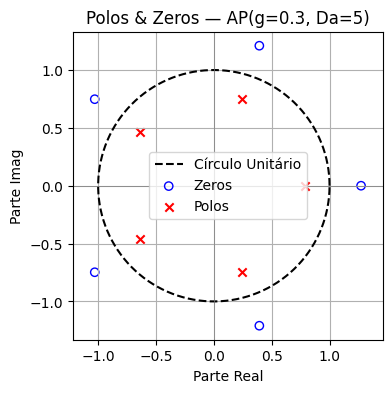

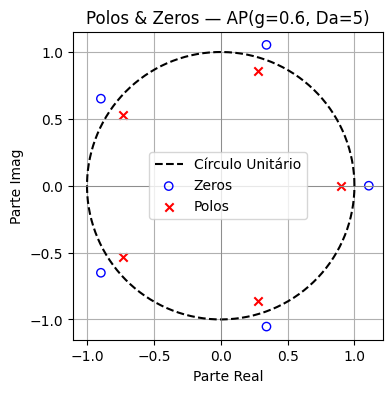

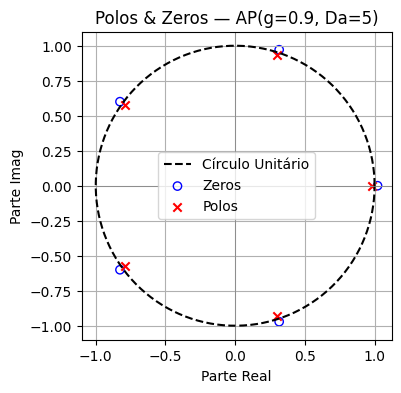

In [ ]:
# Diagrama polos-zeros (polinómios em z para np.roots)
import numpy as np
import matplotlib.pyplot as plt

for g in gains:
    num_z = np.zeros(Da+1, dtype=float)
    den_z = np.zeros(Da+1, dtype=float)
    num_z[0] = -g
    num_z[-1] = 1.0
    den_z[0] = 1.0
    den_z[-1] = -g

    zeros = np.roots(num_z)
    poles = np.roots(den_z)

    plt.figure(figsize=(4,4))
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', label='Círculo Unitário')
    if zeros.size > 0:
        plt.scatter(np.real(zeros), np.imag(zeros), marker='o', facecolors='none', edgecolors='b', label='Zeros')
    if poles.size > 0:
        plt.scatter(np.real(poles), np.imag(poles), marker='x', color='r', label='Polos')
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.legend()
    plt.title(f'Polos & Zeros — AP(g={g}, Da={Da})')
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imag')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


 II) Determine experimentalmente a resposta impulsional. Ilustre graficamente, guarde num ficheiro wave e
escute o resultado.


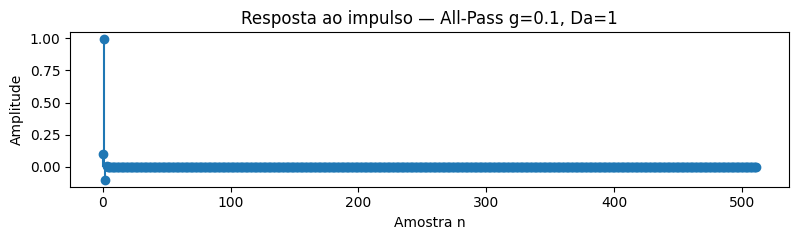

Guardado: impulse_AP_g0.1_Da1.wav


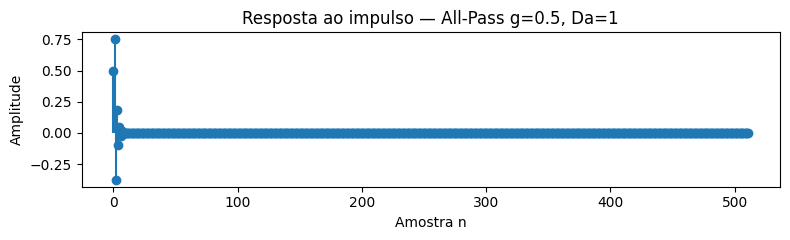

Guardado: impulse_AP_g0.5_Da1.wav


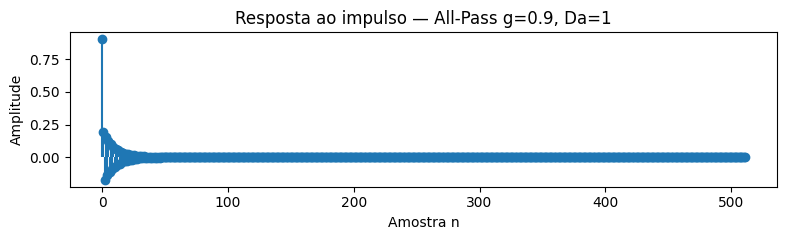

Guardado: impulse_AP_g0.9_Da1.wav


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display

fs = 44100  # taxa de amostragem para o ficheiro WAV
N = 512     # número de amostras da resposta ao impulso

gains = [0.1, 0.5, 0.9]
Da = 1  # atraso em amostras

for g in gains:
    b = np.zeros(Da + 1)
    a = np.zeros(Da + 1)
    b[0] = g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = g

    # impulso unitário
    x = np.zeros(N)
    x[0] = 1.0

    # resposta ao impulso via lfilter
    y = signal.lfilter(b, a, x)

    # plot tempo
    plt.figure(figsize=(8,2.5))
    plt.stem(np.arange(len(y)), y, basefmt=" ")
    plt.title(f"Resposta ao impulso — All-Pass g={g}, Da={Da}")
    plt.xlabel('Amostra n')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    # normalizar para evitar clipping ao escrever WAV
    maxv = np.max(np.abs(y))
    if maxv == 0:
        y_norm = y
    else:
        y_norm = 0.9 * y / maxv

    fname = f"impulse_AP_g{g}_Da{Da}.wav"
    try:
        sf.write(fname, y_norm, fs)
        print(f"Guardado: {fname}")
    except Exception as e:
        print(f"Erro a guardar {fname}: {e}")

    # reproduzir inline (nota: em alguns ambientes Jupyter o player pode não aparecer)
    display(Audio(y_norm, rate=fs))


iii) Aplique este filtro a sinais de teste (que considere adequados) e sinais audio para testar a sua funcionalidade

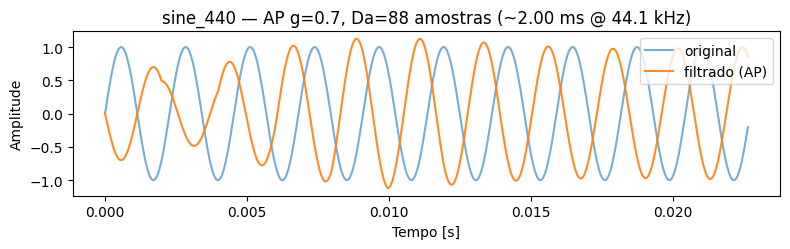

Guardado: ap_outputs/sine_440_AP_g0p7_Da88_fs44100.wav


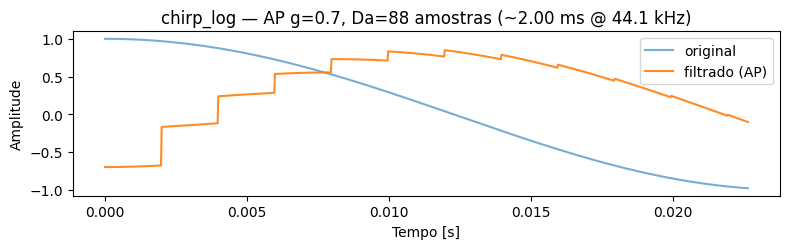

Guardado: ap_outputs/chirp_log_AP_g0p7_Da88_fs44100.wav


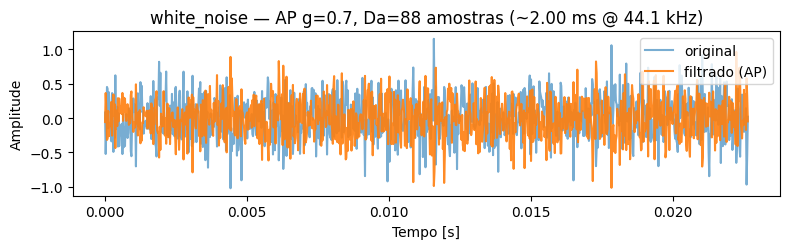

Guardado: ap_outputs/white_noise_AP_g0p7_Da88_fs44100.wav



Guardado (alínea b, wet-only): audio_AP_b_wetonly_g0p7_Da88_(2.0ms)_fs44100.wav


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import soundfile as sf
from IPython.display import Audio, display
import os

g = 0.7         # ganho típico (0.5–0.8)
Da_ms = 2.0     # atraso alvo em milissegundos (1.7–5 ms recomendado)

fs_syn = 44100
dur = 2.0
N = int(fs_syn * dur)
t = np.linspace(0, dur, N, endpoint=False)

signals = {
    'sine_440':   np.sin(2 * np.pi * 440 * t),
    'chirp_log':  signal.chirp(t, f0=20, f1=8000, t1=dur, method='logarithmic'),
    'white_noise': np.random.normal(0, 0.3, size=N),
}

Da_syn = int(round(Da_ms * fs_syn / 1000.0))  # amostras
# Coeficientes AP (enunciado) — inline (sem funções)
b_syn = np.zeros(Da_syn + 1, dtype=np.float32)
a_syn = np.zeros(Da_syn + 1, dtype=np.float32)
b_syn[0] = -g
b_syn[-1] = 1.0
a_syn[0] = 1.0
a_syn[-1] = -g

os.makedirs('ap_outputs', exist_ok=True)

for name, x in signals.items():
    y = signal.lfilter(b_syn, a_syn, x)

    # Plot (primeiros 1000 pontos)
    plt.figure(figsize=(8, 2.6))
    plt.plot(t[:1000], x[:1000], label='original', alpha=0.6)
    plt.plot(t[:1000], y[:1000], label='filtrado (AP)', alpha=0.9)
    plt.title(f'{name} — AP g={g}, Da={Da_syn} amostras (~{Da_ms:.2f} ms @ {fs_syn/1000:.1f} kHz)')
    plt.xlabel('Tempo [s]'); plt.ylabel('Amplitude')
    plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

    # Guardar WAV (mono), normalizado
    maxv = np.max(np.abs(y))
    y_norm = (0.9 * y / maxv) if maxv > 0 else y
    out_wav = f"ap_outputs/{name}_AP_g{str(g).replace('.','p')}_Da{Da_syn}_fs{fs_syn}.wav"
    sf.write(out_wav, y_norm.astype(np.float32), fs_syn)
    print('Guardado:', out_wav)
    try:
        display(Audio(y_norm, rate=fs_syn))
    except Exception:
        pass

in_path = 'audio.wav'
if not os.path.exists(in_path):
    print("\n[AVISO] 'audio.wav' não encontrado na pasta atual. Coloca o ficheiro ao lado do notebook.")
else:
    x, fs = sf.read(in_path, always_2d=True)
    x_mono = x.mean(axis=1).astype(np.float32)

    Da = int(round(Da_ms * fs / 1000.0))  # amostras no fs do áudio

    # Coeficientes AP (enunciado) — inline
    b = np.zeros(Da + 1, dtype=np.float32)
    a = np.zeros(Da + 1, dtype=np.float32)
    b[0] = -g
    b[-1] = 1.0
    a[0] = 1.0
    a[-1] = -g

    # Filtrar
    y = signal.lfilter(b, a, x_mono)

    # Wet-only estéreo (L=wet, R=wet)
    wet_stereo = np.stack([y, y], axis=1).astype(np.float32)

    # Normalizar se necessário
    peak = np.max(np.abs(wet_stereo))
    if peak > 1.0:
        wet_stereo = wet_stereo / (peak + 1e-12)

    outname = f"audio_AP_b_wetonly_g{str(g).replace('.','p')}_Da{Da}_({Da_ms:.1f}ms)_fs{fs}.wav"
    sf.write(outname, wet_stereo, fs)
    print("\nGuardado (alínea b, wet-only):", outname)
    try:
        display(Audio(wet_stereo[:,0], rate=fs))  # ouvir um canal wet
    except Exception:
        pass

